<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import google.colab.drive
google.colab.drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
#!pip install pytorch-lightning

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# **前処理**

In [0]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.RandomHorizontalFlip(), 
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #https://teratail.com/questions/234027
    
    ])

In [0]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ) #多分正規化
    ])

In [0]:
#load train
#学習に用いて良い画像は、STL10のtrain,unlabeled画像のみとする。
#STL10のテスト画像は、上記の運営賞に用いるので、validationとして用いること
train = torchvision.datasets.STL10(
    root=".", 
    split='train', 
    folds=None,                          #０〜９で選べるぽい
    transform=transform_train,                     #読み込み時の処理
    target_transform=None, 
    download=True)

Extracting ./stl10_binary.tar.gz to .


In [0]:
#データセットの中身を確認
train

Dataset STL10
    Number of datapoints: 5000
    Root location: .
    Split: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [0]:
#load test for validation
val = torchvision.datasets.STL10(
    root=".", 
    split="test", 
    folds=None,                          
    transform=transform_val,                     
    target_transform=None, 
    download=True)

Files already downloaded and verified


In [0]:
val

Dataset STL10
    Number of datapoints: 8000
    Root location: .
    Split: test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [0]:
#train[0][0].shape

In [0]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[1][0],(1,2,0))
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


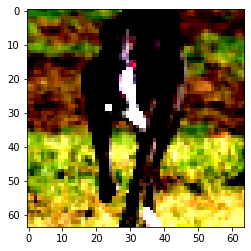

In [0]:
plt.imshow(img)

In [0]:
#type(train[0])

In [0]:
#train[0][0]

In [0]:
#train[1][1]

In [0]:
batch_size = 32

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

classes = ("airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck")

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

# **VGG16ファインチューニング**
参考：https://github.com/YutaroOgawa/pytorch_advanced

In [0]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)
print(model)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [0]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 再学習するパラメーターを指定する
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [0]:

#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-5},
    {'params': params_to_update_2, 'lr': 5e-5},
    {'params': params_to_update_3, 'lr': 1e-4}
], momentum=0.9)

In [0]:
epochs = 60
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

100%|██████████| 250/250 [00:37<00:00,  6.71it/s]


epoch * 1
training loss: 0.0491, training acc 0.5444
validation loss: 0.0283, validation acc0.8253
Validation loss decreased (inf --> 0.028257).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


epoch * 2
training loss: 0.0233, training acc 0.8054
validation loss: 0.0178, validation acc0.8518
Validation loss decreased (0.028257 --> 0.017794).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.68it/s]


epoch * 3
training loss: 0.0175, training acc 0.8220
validation loss: 0.0150, validation acc0.8528
Validation loss decreased (0.017794 --> 0.014999).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.70it/s]


epoch * 4
training loss: 0.0150, training acc 0.8462
validation loss: 0.0131, validation acc0.8670
Validation loss decreased (0.014999 --> 0.013142).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.71it/s]


epoch * 5
training loss: 0.0142, training acc 0.8440
validation loss: 0.0125, validation acc0.8670
Validation loss decreased (0.013142 --> 0.012510).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.68it/s]


epoch * 6
training loss: 0.0138, training acc 0.8432
validation loss: 0.0123, validation acc0.8671
Validation loss decreased (0.012510 --> 0.012315).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


epoch * 7
training loss: 0.0134, training acc 0.8540
validation loss: 0.0118, validation acc0.8716
Validation loss decreased (0.012315 --> 0.011826).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.70it/s]


epoch * 8
training loss: 0.0129, training acc 0.8572
validation loss: 0.0116, validation acc0.8698
Validation loss decreased (0.011826 --> 0.011624).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


epoch * 9
training loss: 0.0126, training acc 0.8592
validation loss: 0.0112, validation acc0.8745
Validation loss decreased (0.011624 --> 0.011241).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.72it/s]


epoch * 10
training loss: 0.0124, training acc 0.8598
validation loss: 0.0112, validation acc0.8756
Validation loss decreased (0.011241 --> 0.011237).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.70it/s]


epoch * 11
training loss: 0.0121, training acc 0.8650
validation loss: 0.0107, validation acc0.8773
Validation loss decreased (0.011237 --> 0.010726).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 12
training loss: 0.0124, training acc 0.8604
validation loss: 0.0109, validation acc0.8788
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 13
training loss: 0.0119, training acc 0.8650
validation loss: 0.0107, validation acc0.8795
EarlyStopping counter: 2 out of 3


100%|██████████| 250/250 [00:36<00:00,  6.77it/s]


epoch * 14
training loss: 0.0116, training acc 0.8696
validation loss: 0.0107, validation acc0.8813
Validation loss decreased (0.010726 --> 0.010699).  Saving model ...


100%|██████████| 250/250 [00:37<00:00,  6.72it/s]


epoch * 15
training loss: 0.0118, training acc 0.8676
validation loss: 0.0104, validation acc0.8825
Validation loss decreased (0.010699 --> 0.010397).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 16
training loss: 0.0111, training acc 0.8722
validation loss: 0.0105, validation acc0.8831
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 17
training loss: 0.0111, training acc 0.8720
validation loss: 0.0105, validation acc0.8823
EarlyStopping counter: 2 out of 3


100%|██████████| 250/250 [00:37<00:00,  6.74it/s]


epoch * 18
training loss: 0.0113, training acc 0.8692
validation loss: 0.0106, validation acc0.8835
EarlyStopping counter: 3 out of 3
Early stopping


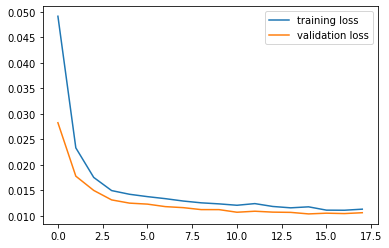

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

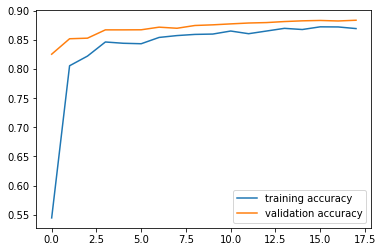

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

**混同行列**
参考：https://github.com/takoroy/mypytorch-memo

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import pandas as pd
    sns.set()
    
    df = pd.DataFrame(cm)
    df.index = labels
    df.columns = labels

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, annot=True, fmt="d", linewidths=.5, ax=ax)

def validation_confusion_matrix(model):
    images_so_far = 0
    fig = plt.figure()

    all_labels = np.array([])
    all_preds = np.array([])
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, labels.cpu().data.numpy())
        all_preds = np.append(all_preds, preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

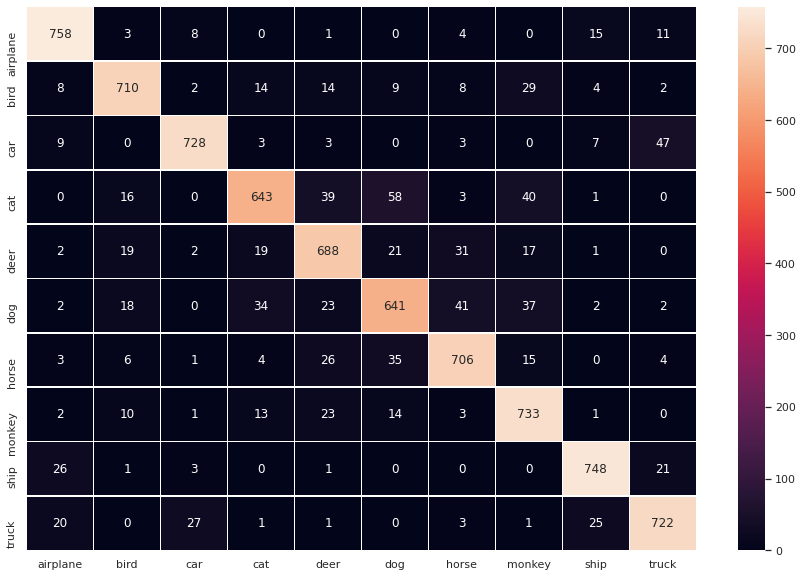

In [0]:
validation_confusion_matrix(model)

# **DenseNet**

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.densenet161(pretrained=use_pretrained).to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [0]:
model.classifier = nn.Linear(in_features=2208, out_features=10, bias=True).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [0]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
#https://qiita.com/koshian2/items/4f91ac5cceb6125fd57e

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []
params_to_update_4 = []


# 再学習するパラメーターを指定する
update_param_names_1 = ["denseblock2"]
update_param_names_2 = ["denseblock3"]
update_param_names_3 = ["denseblock4"]
update_param_names_4 = ["classifier.weight", "classifier.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif update_param_names_2[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)
    
    elif update_param_names_3[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_4:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

勾配計算なし。学習しない： features.conv0.weight
勾配計算なし。学習しない： features.norm0.weight
勾配計算なし。学習しない： features.norm0.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer3.conv1.weight
勾配計算

In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 1e-4},
    {'params': params_to_update_3, 'lr': 1e-4},
    {'params': params_to_update_4, 'lr': 1e-3}
], momentum=0.9)

In [15]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
#save_path = './weights.pth'
#torch.save(model.state_dict(), save_path)

100%|██████████| 250/250 [00:47<00:00,  5.24it/s]


epoch * 1
training loss: 0.0608, training acc 0.4800
validation loss: 0.0465, validation acc0.7725
Validation loss decreased (inf --> 0.046501).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 2
training loss: 0.0383, training acc 0.8170
validation loss: 0.0287, validation acc0.8555
Validation loss decreased (0.046501 --> 0.028736).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 3
training loss: 0.0261, training acc 0.8620
validation loss: 0.0200, validation acc0.8804
Validation loss decreased (0.028736 --> 0.019985).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 4
training loss: 0.0200, training acc 0.8666
validation loss: 0.0158, validation acc0.8880
Validation loss decreased (0.019985 --> 0.015828).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 5
training loss: 0.0169, training acc 0.8708
validation loss: 0.0136, validation acc0.8905
Validation loss decreased (0.015828 --> 0.013648).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 6
training loss: 0.0146, training acc 0.8820
validation loss: 0.0119, validation acc0.9048
Validation loss decreased (0.013648 --> 0.011903).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 7
training loss: 0.0134, training acc 0.8854
validation loss: 0.0109, validation acc0.9051
Validation loss decreased (0.011903 --> 0.010856).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 8
training loss: 0.0124, training acc 0.8894
validation loss: 0.0104, validation acc0.9020
Validation loss decreased (0.010856 --> 0.010426).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 9
training loss: 0.0117, training acc 0.8964
validation loss: 0.0099, validation acc0.9053
Validation loss decreased (0.010426 --> 0.009870).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 10
training loss: 0.0111, training acc 0.8938
validation loss: 0.0093, validation acc0.9144
Validation loss decreased (0.009870 --> 0.009274).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 11
training loss: 0.0105, training acc 0.9008
validation loss: 0.0091, validation acc0.9059
Validation loss decreased (0.009274 --> 0.009130).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 12
training loss: 0.0103, training acc 0.8992
validation loss: 0.0089, validation acc0.9114
Validation loss decreased (0.009130 --> 0.008948).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 13
training loss: 0.0094, training acc 0.9122
validation loss: 0.0084, validation acc0.9144
Validation loss decreased (0.008948 --> 0.008418).  Saving model ...


100%|██████████| 250/250 [00:47<00:00,  5.24it/s]


epoch * 14
training loss: 0.0094, training acc 0.9126
validation loss: 0.0081, validation acc0.9200
Validation loss decreased (0.008418 --> 0.008064).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 15
training loss: 0.0092, training acc 0.9088
validation loss: 0.0081, validation acc0.9184
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 16
training loss: 0.0089, training acc 0.9154
validation loss: 0.0080, validation acc0.9174
Validation loss decreased (0.008064 --> 0.008010).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 17
training loss: 0.0088, training acc 0.9142
validation loss: 0.0077, validation acc0.9209
Validation loss decreased (0.008010 --> 0.007728).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 18
training loss: 0.0081, training acc 0.9176
validation loss: 0.0076, validation acc0.9213
Validation loss decreased (0.007728 --> 0.007624).  Saving model ...


100%|██████████| 250/250 [00:47<00:00,  5.25it/s]


epoch * 19
training loss: 0.0082, training acc 0.9200
validation loss: 0.0072, validation acc0.9238
Validation loss decreased (0.007624 --> 0.007235).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 20
training loss: 0.0084, training acc 0.9170
validation loss: 0.0073, validation acc0.9226
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 21
training loss: 0.0078, training acc 0.9202
validation loss: 0.0073, validation acc0.9204
EarlyStopping counter: 2 out of 3


100%|██████████| 250/250 [00:47<00:00,  5.26it/s]

epoch * 22
training loss: 0.0079, training acc 0.9254
validation loss: 0.0073, validation acc0.9231
EarlyStopping counter: 3 out of 3
Early stopping


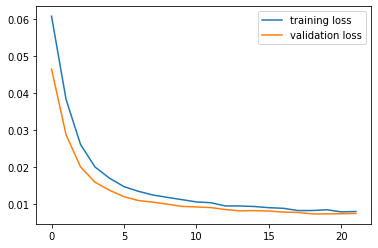

In [16]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

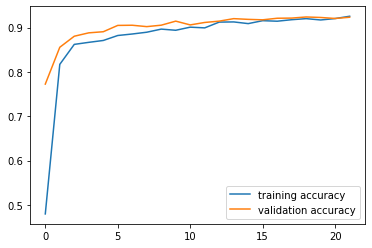

In [17]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

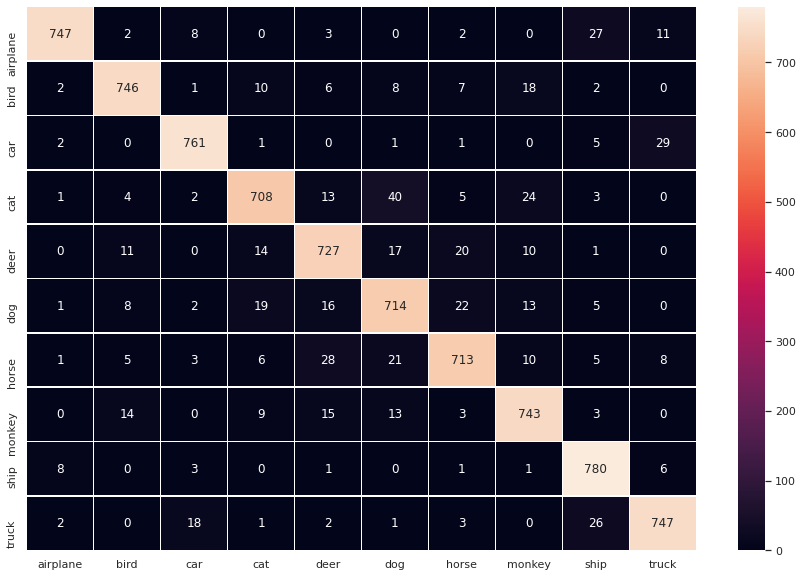

In [20]:
validation_confusion_matrix(model)